In [1]:
# !pip install catboost
# !pip install pycaret
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import datetime as dt
from pycaret.regression import *
import matplotlib.pyplot as plt
import seaborn as sns

#-------------------- 주피터 셀 넓이 조절 ---------------------
from IPython.core.display import display, HTML
display(HTML("<style>.container{width:100% !important;}</style>"))
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('max_colwidth', None)


In [2]:
import matplotlib.font_manager as fm
import matplotlib as mpl
mpl.rcParams['axes.unicode_minus'] = False
mpl.rcParams["figure.figsize"] = (8,4)
mpl.rcParams['axes.grid'] = True 
path = 'C:\\Windows\\Fonts\\\x7f\x7f\x7f\x7fBOLD.TTF'
font_name = fm.FontProperties(fname=path, size=10).get_name()
print(font_name)
plt.rc('font', family=font_name)
# plt.title('한글제목')
# plt.show()


NanumGothic


In [3]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

### 변수 간 관계 시각화

In [4]:
import re 
text = ' 쌀밥 /잡곡밥 (쌀,현미흑미:국내산) 오징어찌개  쇠불고기 쇠고기:호주산) 계란찜  청포묵무침  요구르트  포기김치 (배추,고추가루:국내산) '
text = re.sub(r'/^\s+|\s+$/g', '', text.strip())#앞뒤 공백 제거
text = text.replace(r' /','/')  #앞뒤 공백 제거
text = text.replace(r'/ ','/')  #앞뒤 공백 제거
  
list = text.split()
relist = []
for item in list:
    item = re.sub(r'\([^)]*\)', '', item.strip())  #(s) 제거
    item = re.sub(r'[^)]*\)', '', item.strip())    #s) 제거
    item = re.sub(r'\([^)]*', '', item.strip())    #(s 제거
    item = re.sub(' +', ' ', item.strip())       #공백,탭 제거
    if len(item) > 0:
        relist.append(item)
print(list)
print(relist)

['쌀밥/잡곡밥', '(쌀,현미흑미:국내산)', '오징어찌개', '쇠불고기', '쇠고기:호주산)', '계란찜', '청포묵무침', '요구르트', '포기김치', '(배추,고추가루:국내산)']
['쌀밥/잡곡밥', '오징어찌개', '쇠불고기', '계란찜', '청포묵무침', '요구르트', '포기김치']


* 정규표현식
<pre>
특정문자 제거            : str.replace(/\-/g,'');
앞의 공백 제거           : str.replace(/^\s+/,'');
뒤의 공백 제거          : str.replace(/\s+$/,'');
앞뒤 공백 제거          : str.replace(/^\s+|\s+$/g,'');
문자열 내의 공백 제거  : str.replace(/\s/g,'');
개행 제거                : str.replace(/\n/g,'');
엔터 제거                : str.replace(/\r/g,'');
0 제거                   : str.replace(/[^(1-9)]/gi,"");

In [5]:
# re.sub(r'[^(소고기)]/g', 'ㅁ', '매운소고기무국'.strip())    # 양배추 뒤 제거     


In [6]:
def reg_exclude_(text):
    text = re.sub(r'/^\s+|\s+$/g', '', text.strip())#앞뒤 공백 제거
    text = text.replace(r' /','/')  #앞뒤 공백 제거
    text = text.replace(r'/ ','/')  #앞뒤 공백 제거

    list = text.split()
    relist = []
    for item in list:
        item = re.sub(r'\([^)]*\)', '', item.strip())               #(s) 제거
        item = re.sub(r'\/.+?$', '', item.strip())                  # /s 제거        
        item = re.sub(r'\양배추.+?$', '양배추', item.strip())        # 양배추 뒤 제거   
        item = re.sub(r'\영양밥.+?$', '영양밥', item.strip())        # 콩나물밥 뒤 제거   
        
        item = re.sub(r'\*[^)]*', '', item.strip())                           # * 뒤 제거   
        item = re.sub(r'[^비빔밥]*\비빔밥', '비빔밥', item.strip())             # 비빔밥 앞제거
        item = re.sub(r'[^불고기덮밥]*\불고기덮밥', '고기덮밥', item.strip())    # 고기덮밥 앞제거
        item = re.sub(r'[^영양밥]*\영양밥', '영양밥', item.strip())             # 영양밥 앞제거
        item = re.sub(r'[^볶음밥]*\볶음밥', '볶음밥', item.strip())             # 볶음밥 앞제거
        item = re.sub(r'[^카레라이스]*\카레라이스', '카레라이스', item.strip())  # 카레라이스 앞제거
        item = re.sub(r'[^카레라이스]*\카레라이스', '카레라이스', item.strip())  # 카레라이스 앞제거
        item = re.sub(r'[^콩나물밥]*\콩나물밥', '콩나물밥', item.strip())       # 콩나물밥 앞제거
        item = item.strip().replace('짜장밥', '짜장덮밥')
        item = item.strip().replace('카레라이스', '카레덮밥')
        item = item.strip().replace('김치제육덮밥', '고기덮밥')
        item = item.strip().replace('돈육버섯고추장덮밥', '고기덮밥')
        item = item.strip().replace('김치필라프', '볶음밥') 
        item = item.strip().replace('김치볶음밥', '볶음밥') 
        item = item.strip().replace('김밥볶음밥', '볶음밥')
        
        item = re.sub(r'\소고기[^국]*', '', item.strip())                #소고기 뒤 제거
        
        item = re.sub(r'[^)]*\)', '', item.strip())                #s) 제거
        item = re.sub(r'\([^)]*', '', item.strip())                #(s 제거
        item = re.sub(' +', ' ', item.strip())                     #공백,탭 제거
        if len(item) > 0:
            relist.append(item)
    return ' '.join(relist)
train['중식메뉴2'] = train['중식메뉴'].apply(lambda x: reg_exclude_(x))

In [7]:
 train[['중식메뉴','중식메뉴2']].head()

,중식메뉴,중식메뉴2
0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 청포묵무침 요구르트 포기김치 (배추,고추가루:국내산)",쌀밥 오징어찌개 쇠불고기 계란찜 청포묵무침 요구르트 포기김치
1,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무침 요구르트 배추겉절이 (배추,고추가루:국내산)",쌀밥 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무침 요구르트 배추겉절이
2,"카레덮밥 (쌀,현미흑미:국내산) 팽이장국 치킨핑거 (닭고기:국내산) 쫄면야채무침 견과류조림 요구르트 포기김치 (배추,고추가루:국내산)",카레덮밥 팽이장국 치킨핑거 쫄면야채무침 견과류조림 요구르트 포기김치
3,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 쇠고기무국 주꾸미볶음 부추전 시금치나물 요구르트 포기김치 (배추,고추가루:국내산)",쌀밥 쇠고기무국 주꾸미볶음 부추전 시금치나물 요구르트 포기김치
4,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 떡국 돈육씨앗강정 (돼지고기:국내산) 우엉잡채 청경채무침 요구르트 포기김치 (배추,고추가루:국내산)",쌀밥 떡국 돈육씨앗강정 우엉잡채 청경채무침 요구르트 포기김치


In [8]:
lens = [len(row) for row in train['중식메뉴2'].str.split().tolist()]
np.unique(lens)

array([5, 6, 7, 8])

In [9]:
#[['bab', 'soup', 'kimchi', 'menu1', 'menu2', 'menu3', 'menu4']]
menu = pd.DataFrame(train['중식메뉴2'].str.split().tolist(), columns=["m1","m2","m3","m4","m5","m6","m7","m8"])
print(menu.shape)
menu.head()


(1205, 8)


,m1,m2,m3,m4,m5,m6,m7,m8
0,쌀밥,오징어찌개,쇠불고기,계란찜,청포묵무침,요구르트,포기김치,None
1,쌀밥,김치찌개,가자미튀김,모둠소세지구이,마늘쫑무침,요구르트,배추겉절이,None
2,카레덮밥,팽이장국,치킨핑거,쫄면야채무침,견과류조림,요구르트,포기김치,None
3,쌀밥,쇠고기무국,주꾸미볶음,부추전,시금치나물,요구르트,포기김치,None
4,쌀밥,떡국,돈육씨앗강정,우엉잡채,청경채무침,요구르트,포기김치,None


In [10]:
menu['m1'].unique() 

array(['쌀밥', '카레덮밥', '비빔밥', '곤드레밥', '콩나물밥', '영양밥', '볶음밥', '참치회덮밥',
       '연복풍덮밥', '고기덮밥', '짜장덮밥', '오곡밥', '<초복특식>', '삼계탕', '마파두부덮밥', '오므라이스'],
      dtype=object)

In [11]:
menu[~menu['m6'].isna()].tail(100)

,m1,m2,m3,m4,m5,m6,m7,m8
1105,쌀밥,시금치된장국,카레닭찜,김치빈대떡,고구마순볶음,포기김치,시리얼&요거트,None
1106,쌀밥,나주곰탕,적어구이&양념장,한식잡채,얼갈이나물,석박지,그린샐러드,None
1107,쌀밥,다슬기아욱국,돈사태김치찜,닭살겨자냉채,삼색유자청무침,열무김치,모닝샌드,None
1108,쌀밥,순두부찌개,소불고기,코다리강정,노각생채,포기김치,견과류샐러드,None
1109,쌀밥,황태콩나물해장국,궁보계정,시금치프리타타,가지고추장무침,포기김치,양상추샐러드,None
1110,쌀밥,우거지국,매콤돼지갈비찜,삼색만두채소무침,호박채나물볶음,포기김치,황도샐러드,None
1111,쌀밥,오리들깨탕,냉족발야채무침,수제오미산적,부추샐러드,포기김치,꽃맛살샐러드,None
1112,쌀밥,매운계란파국,마파두부,치킨핑거,쫄면채소무침,열무김치,그린샐러드,None
1113,쌀밥,옹심이만두국,대패삽겹숙주볶음,오징어초무침,양배추,포기김치,양상추샐러드,None
1114,쌀밥,아욱된장국,생선까스,마카로니치즈범벅,오이사과무침,포기김치,양상추샐러드,None


In [12]:
menu.drop(['m6','m7','m8'], axis=1, inplace=True)

In [13]:
menu.head()

,m1,m2,m3,m4,m5
0,쌀밥,오징어찌개,쇠불고기,계란찜,청포묵무침
1,쌀밥,김치찌개,가자미튀김,모둠소세지구이,마늘쫑무침
2,카레덮밥,팽이장국,치킨핑거,쫄면야채무침,견과류조림
3,쌀밥,쇠고기무국,주꾸미볶음,부추전,시금치나물
4,쌀밥,떡국,돈육씨앗강정,우엉잡채,청경채무침


In [14]:
menu.to_csv("menu.csv")

## NLP
* 2021.06.12 기준
* 메뉴의 종류를 원-핫 인코딩으로 분류시켜서 학습시키니 성능 상승
* '주' 및 '월' 데이터를 추가해서 연초 연말 월초 월말 알아서 학습 유도

In [15]:
 train['중식메뉴']

0        쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개  쇠불고기 (쇠고기:호주산) 계란찜  청포묵무침  요구르트  포기김치 (배추,고추가루:국내산) 
1            쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개  가자미튀김  모둠소세지구이  마늘쫑무침  요구르트  배추겉절이 (배추,고추가루:국내산) 
2        카레덮밥 (쌀,현미흑미:국내산) 팽이장국  치킨핑거 (닭고기:국내산) 쫄면야채무침  견과류조림  요구르트  포기김치 (배추,고추가루:국내산) 
3                쌀밥/잡곡밥 (쌀,현미흑미:국내산) 쇠고기무국  주꾸미볶음  부추전  시금치나물  요구르트  포기김치 (배추,고추가루:국내산) 
4       쌀밥/잡곡밥 (쌀,현미흑미:국내산) 떡국  돈육씨앗강정 (돼지고기:국내산) 우엉잡채  청경채무침  요구르트  포기김치 (배추,고추가루:국내산) 
                                              ...                                       
1200                        쌀밥/흑미밥/찰현미밥 아욱국 수제함박스테이크 견과류마카로니범벅 생깻잎지 단호박물김치 양상추샐러드*오리엔탈D 
1201                               쌀밥/수수밥/찰현미밥 냉이된장국 동파육 봄동전 청경채/버섯숙회*초장 무생채 양상추샐러드*파인D 
1202                                전주비빔밥*약고추장 계란파국 요거닭 올방개묵무침 파프리카해초무침 포기김치 양상추샐러드*자몽D 
1203                 쌀밥/흑미밥/찰현미밥 전주식콩나물해장국 돈육간장불고기 깐풍연근 연두부*달래양념장 봄동겉절이/양념김 양상추샐러드*오렌지D 
1204                    쌀밥/귀리밥/찰현미밥 들깨미역국 교촌간장치킨 옥수수콘치즈구이 가지고추장무침 포기김치/요구르트 양배추샐러드*사우전D 
Name: 중식메뉴, Length: 1

#### 메뉴 임베딩

(-0.5, 399.5, 199.5, -0.5)

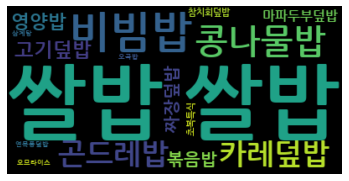

In [16]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure()

text = " ".join(menu['m1'])
wordcloud = WordCloud(max_font_size=100, font_path='C:\\Windows\\Fonts\\\x7f\x7f\x7f\x7fBOLD.TTF').generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')


(-0.5, 399.5, 199.5, -0.5)

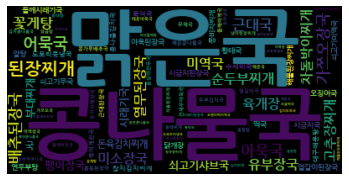

In [17]:
text = " ".join(menu['m2'])
wordcloud = WordCloud(max_font_size=100, font_path='C:\\Windows\\Fonts\\\x7f\x7f\x7f\x7fBOLD.TTF').generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

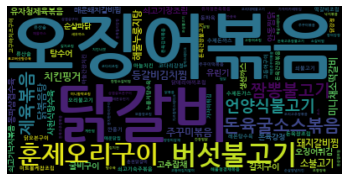

In [18]:
text = " ".join(menu['m3'])
wordcloud = WordCloud(max_font_size=100, font_path='C:\\Windows\\Fonts\\\x7f\x7f\x7f\x7fBOLD.TTF').generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

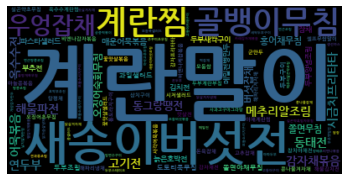

In [19]:
text = " ".join(menu['m4'])
wordcloud = WordCloud(max_font_size=100, font_path='C:\\Windows\\Fonts\\\x7f\x7f\x7f\x7fBOLD.TTF').generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

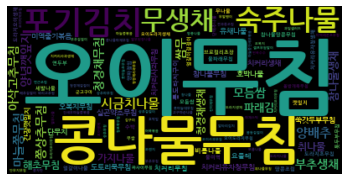

In [20]:
text = " ".join(menu['m5'])
wordcloud = WordCloud(max_font_size=100, font_path='C:\\Windows\\Fonts\\\x7f\x7f\x7f\x7fBOLD.TTF').generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')